In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTEENN
from collections import Counter
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.decomposition import PCA

# Ensure the directories for saving data exist
def create_directories():
    if not os.path.exists('data/'):
        os.makedirs('data/')
        print("Created directory: data/")
    if not os.path.exists('models/'):
        os.makedirs('models/')
        print("Created directory: models/")

create_directories()  # Create the necessary directories


Created directory: data/


In [26]:
'''
duration: continuous.
protocol_type: symbolic.
service: symbolic.
flag: symbolic.
src_bytes: continuous.
dst_bytes: continuous.
land: symbolic.
wrong_fragment: continuous.
urgent: continuous.
hot: continuous.
num_failed_logins: continuous.
logged_in: symbolic.
num_compromised: continuous.
root_shell: continuous.
su_attempted: continuous.
num_root: continuous.
num_file_creations: continuous.
num_shells: continuous.
num_access_files: continuous.
num_outbound_cmds: continuous.
is_host_login: symbolic.
is_guest_login: symbolic.
count: continuous.
srv_count: continuous.
serror_rate: continuous.
srv_serror_rate: continuous.
rerror_rate: continuous.
srv_rerror_rate: continuous.
same_srv_rate: continuous.
diff_srv_rate: continuous.
srv_diff_host_rate: continuous.
dst_host_count: continuous.
dst_host_srv_count: continuous.
dst_host_same_srv_rate: continuous.
dst_host_diff_srv_rate: continuous.
dst_host_same_src_port_rate: continuous.
dst_host_srv_diff_host_rate: continuous.
dst_host_serror_rate: continuous.
dst_host_srv_serror_rate: continuous.
dst_host_rerror_rate: continuous.
dst_host_srv_rerror_rate: continuous.
'''


'\nduration: continuous.\nprotocol_type: symbolic.\nservice: symbolic.\nflag: symbolic.\nsrc_bytes: continuous.\ndst_bytes: continuous.\nland: symbolic.\nwrong_fragment: continuous.\nurgent: continuous.\nhot: continuous.\nnum_failed_logins: continuous.\nlogged_in: symbolic.\nnum_compromised: continuous.\nroot_shell: continuous.\nsu_attempted: continuous.\nnum_root: continuous.\nnum_file_creations: continuous.\nnum_shells: continuous.\nnum_access_files: continuous.\nnum_outbound_cmds: continuous.\nis_host_login: symbolic.\nis_guest_login: symbolic.\ncount: continuous.\nsrv_count: continuous.\nserror_rate: continuous.\nsrv_serror_rate: continuous.\nrerror_rate: continuous.\nsrv_rerror_rate: continuous.\nsame_srv_rate: continuous.\ndiff_srv_rate: continuous.\nsrv_diff_host_rate: continuous.\ndst_host_count: continuous.\ndst_host_srv_count: continuous.\ndst_host_same_srv_rate: continuous.\ndst_host_diff_srv_rate: continuous.\ndst_host_same_src_port_rate: continuous.\ndst_host_srv_diff_host

In [27]:
def save_model_instance(instance, filename):
    print(f"Saving model instance: {filename}...")
    np.save(f'/home/dcll/hugging_face_learning/FineTuning_GPT2Model/gpt2_fine_tuned/model/ML-Project-Network_Intrusion_Detection/models/{filename}.npy', instance)

In [28]:
# Load and split dataset
def load_and_split_data(df, target_column='outcome', test_size=0.2, random_state=42):
    print("Loading and splitting the dataset...")
    X = df.drop(target_column, axis=1)  # Features
    Y = df[target_column]  # Target
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state, stratify=Y)

    # Save the split data
    X_train.to_csv('data/X_train.csv', index=False)
    X_test.to_csv('data/X_test.csv', index=False)
    Y_train.to_csv('data/Y_train.csv', index=False)
    Y_test.to_csv('data/Y_test.csv', index=False)

    print("Data split into training and testing sets.")
    return X_train, X_test, Y_train, Y_test


# Categorize the attack types into the 5 classes
def categorize_attack_type(label):
    if label in dos_attacks:
        return 'DOS'
    elif label in r2l_attacks:
        return 'R2L'
    elif label in u2r_attacks:
        return 'U2R'
    elif label in probe_attacks:
        return 'probing'
    else:
        return 'normal'
    

# Example Usage
df = pd.read_csv('data/data_with_column_names.csv')  # Replace with your actual dataset

dos_attacks = ['smurf.', 'neptune.', 'back.', 'teardrop.', 'pod.', 'land.']
r2l_attacks = ['warezclient.', 'guess_passwd.', 'imap.', 'warezmaster.', 'ftp_write.', 'phf.', 'spy.', 'multihop.']
u2r_attacks = ['buffer_overflow.', 'loadmodule.', 'rootkit.', 'perl.']
probe_attacks = ['satan.', 'ipsweep.', 'portsweep.', 'nmap.']
df['outcome'] = df['outcome'].apply(categorize_attack_type)


target_column = 'outcome'  # Define your target column
# X_train, X_test, Y_train, Y_test = load_and_split_data(df, target_column)

In [29]:
# One-hot encoding categorical features
def one_hot_encode(X_train, X_test, categorical_columns):
    print("One-hot encoding categorical features...")
    encoders = {}
    X_train_encoded_list = []
    X_test_encoded_list = []
    feature_names = []

    # Loop through each categorical column and apply OneHotEncoder
    for col in categorical_columns:
        encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        
        # Fit and transform the training data
        X_train_col_encoded = encoder.fit_transform(X_train[[col]])
        X_train_encoded_list.append(X_train_col_encoded)
        
        # Transform the test data
        X_test_col_encoded = encoder.transform(X_test[[col]])
        X_test_encoded_list.append(X_test_col_encoded)

        # Store the encoder for potential future use
        encoders[col] = encoder
        
        # Get feature names and add to the feature names list
        feature_names.extend(encoder.get_feature_names_out([col]))

        # save the encoder as encoder_{col}.npy
        save_model_instance(encoder, f'encoder_{col}')
    
    # Concatenate the encoded columns into a single matrix
    X_train_encoded = np.concatenate(X_train_encoded_list, axis=1)
    X_test_encoded = np.concatenate(X_test_encoded_list, axis=1)

    # Remove original categorical columns from X_train and X_test
    X_train_remaining = X_train.drop(columns=categorical_columns)
    X_test_remaining = X_test.drop(columns=categorical_columns)
    
    # Concatenate the remaining columns with the one-hot encoded columns
    X_train_final = np.concatenate([X_train_remaining.values, X_train_encoded], axis=1)
    X_test_final = np.concatenate([X_test_remaining.values, X_test_encoded], axis=1)
    
    # Ensure the directory exists before saving the files
    if not os.path.exists('data'):
        os.makedirs('data')

    # Save the encoded data
    np.save('data/X_train_encoded.npy', X_train_final)
    np.save('data/X_test_encoded.npy', X_test_final)

    print("Categorical features encoded and original columns removed.")
    return X_train_final, X_test_final, encoders

# Example usage with specified categorical columns
categorical_columns = ['protocol_type', 'service', 'flag']
# X_train_encoded, X_test_encoded, encoders = one_hot_encode(X_train, X_test, categorical_columns)

In [30]:
# Apply Robust Scaling
def robust_scale(X_train, X_test):
    print("Applying robust scaling...")
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Save the scaled data
    np.save('data/X_train_scaled.npy', X_train_scaled)
    np.save('data/X_test_scaled.npy', X_test_scaled)

    print("Data scaled using RobustScaler.")

    save_model_instance(scaler, 'scaler')
    return X_train_scaled, X_test_scaled, scaler

# X_train_scaled, X_test_scaled, scaler = robust_scale(X_train_encoded, X_test_encoded)


In [31]:
import numpy as np
from collections import Counter
from imblearn.combine import SMOTEENN  # Import SMOTEENN

# Apply SMOTEENN resampling
def apply_smoteenn(X_train, Y_train):
    print("Applying SMOTEENN for resampling...")
    
    # Initialize SMOTEENN with a suitable k_neighbors
    smote_enn = SMOTEENN(sampling_strategy='auto', random_state=42)
    
    # Fit and resample the training data
    X_train_resampled, Y_train_resampled = smote_enn.fit_resample(X_train, Y_train)

    # Save resampled data
    np.save('data/X_train_resampled.npy', X_train_resampled)
    np.save('data/Y_train_resampled.npy', Y_train_resampled)

    print("Data resampled using SMOTEENN.")
    print(f"Resampled Y distribution: {Counter(Y_train_resampled)}")

    # dump resampled data into resampled_data.csv
    resampled_data = pd.DataFrame(X_train_resampled)
    resampled_data['outcome'] = Y_train_resampled
    resampled_data.to_csv('resampled_data.csv', index=False)

    
    return X_train_resampled, Y_train_resampled

# Assuming X_train_scaled and Y_train are defined and preprocessed
# X_train_resampled, Y_train_resampled = apply_smoteenn(X_train_scaled, Y_train)

In [32]:
from sklearn.preprocessing import LabelEncoder

def feature_selection(X_train, Y_train, variance_threshold=0.01, k_best=20, correlation_threshold=0.1):
    print("Starting feature selection...")

    # Variance Threshold
    vt = VarianceThreshold(threshold=variance_threshold)
    X_train_var = vt.fit_transform(X_train)

    # Calculate correlation matrix
    correlation_matrix = pd.DataFrame(X_train_var).corrwith(pd.Series(Y_train))
    low_corr_features = correlation_matrix[correlation_matrix.abs() < correlation_threshold].index
    # add these features in a npy file that conain all deleted features highly and low correlated
    np.save('data/low_corr_features.npy', low_corr_features)

    X_train_var = np.delete(X_train_var, low_corr_features, axis=1)

    print(f"Removed low correlation features: {low_corr_features.tolist()}")

    # Keep one feature from highly correlated features
    corr_matrix = pd.DataFrame(X_train_var).corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
    np.save('data/high_corr_features.npy', to_drop)

    # Retain only one feature from the highly correlated ones
    X_train_var = np.delete(X_train_var, to_drop, axis=1)
    print(f"Removed highly correlated features: {to_drop}")

    # Mutual Information to select K best features
    selector = SelectKBest(mutual_info_classif, k=k_best)
    X_train_selected = selector.fit_transform(X_train_var, Y_train)

    # Save the selected features
    np.save('data/X_train_selected.npy', X_train_selected)

    print(f"Selected {k_best} best features using mutual information.")
    save_model_instance(selector, 'selector')
    return X_train_selected, selector

# X_train_selected, selector = feature_selection(X_train_resampled, Y_train_resampled)


In [33]:
# #CODE FOR OULTLIER REMOVAL

# import numpy as np
# import pandas as pd
# from sklearn.ensemble import IsolationForest
# from sklearn.neighbors import LocalOutlierFactor
# from sklearn.covariance import EllipticEnvelope
# from sklearn.preprocessing import LabelEncoder, RobustScaler
# from sklearn.metrics import classification_report, accuracy_score
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import train_test_split

# # Example data: Replace this with your actual data
# # df = pd.read_csv('your_data.csv')
# # Assuming df is your dataframe with features and 'outcome' column as the target
# X = df.drop('outcome', axis=1)
# Y = df['outcome']

# # Split into train and test sets
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

# # Apply one-hot encoding to categorical features
# from sklearn.preprocessing import OneHotEncoder

# encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# X_train_1 = encoder.fit_transform(X_train[['protocol_type']])
# X_test_1 = encoder.transform(X_test[['protocol_type']])

# X_train_2 = encoder.fit_transform(X_train[['service']])
# X_test_2 = encoder.transform(X_test[['service']])

# X_train_3 = encoder.fit_transform(X_train[['flag']])
# X_test_3 = encoder.transform(X_test[['flag']])

# # Concatenate encoded and numeric features
# X_train_combined = np.concatenate([X_train_1, X_train_2, X_train_3, X_train.drop(['protocol_type', 'service', 'flag'], axis=1).values], axis=1)
# X_test_combined = np.concatenate([X_test_1, X_test_2, X_test_3, X_test.drop(['protocol_type', 'service', 'flag'], axis=1).values], axis=1)

# # Initialize RobustScaler and apply it to the training set
# scaler = RobustScaler()
# X_train_scaled = scaler.fit_transform(X_train_combined)
# X_test_scaled = scaler.transform(X_test_combined)

# # Encode the target variable
# label_encoder = LabelEncoder()
# Y_train_encoded = label_encoder.fit_transform(Y_train)
# Y_test_encoded = label_encoder.transform(Y_test)

# # --------------------------------
# # Step 1: Detect Outliers (Isolation Forest, LOF, Elliptic Envelope)
# # --------------------------------

# # Isolation Forest
# iso_forest = IsolationForest(contamination=0.1, random_state=42)
# iso_forest.fit(X_train_scaled)
# train_iso_pred = iso_forest.predict(X_train_scaled)
# test_iso_pred = iso_forest.predict(X_test_scaled)

# # Local Outlier Factor (LOF)
# lof = LocalOutlierFactor(contamination=0.1)
# train_lof_pred = lof.fit_predict(X_train_scaled)

# # Elliptic Envelope
# elliptic = EllipticEnvelope(contamination=0.1)
# elliptic.fit(X_train_scaled)
# train_elliptic_pred = elliptic.predict(X_train_scaled)
# test_elliptic_pred = elliptic.predict(X_test_scaled)

# # Convert outliers (-1) to 1, inliers (1) to 0 for binary classification
# train_iso_pred[train_iso_pred == 1] = 0
# train_iso_pred[train_iso_pred == -1] = 1
# test_iso_pred[test_iso_pred == 1] = 0
# test_iso_pred[test_iso_pred == -1] = 1

# train_lof_pred[train_lof_pred == 1] = 0
# train_lof_pred[train_lof_pred == -1] = 1

# train_elliptic_pred[train_elliptic_pred == 1] = 0
# train_elliptic_pred[train_elliptic_pred == -1] = 1
# test_elliptic_pred[test_elliptic_pred == 1] = 0
# test_elliptic_pred[test_elliptic_pred == -1] = 1

# # --------------------------------
# # Step 2: Remove Outliers Based on Isolation Forest
# # --------------------------------

# # Filter out outliers (where prediction is 0)
# X_train_cleaned = X_train_scaled[train_iso_pred == 0]
# Y_train_cleaned = Y_train_encoded[train_iso_pred == 0]

# X_test_cleaned = X_test_scaled[test_iso_pred == 0]
# Y_test_cleaned = Y_test_encoded[test_iso_pred == 0]

# # --------------------------------
# # Step 3: Train Classifier After Removing Outliers
# # --------------------------------

# # Example classifier: Logistic Regression
# clf = LogisticRegression(random_state=42)
# clf.fit(X_train_cleaned, Y_train_cleaned)

# # Make predictions on cleaned test set
# predictions = clf.predict(X_test_cleaned)

# # Evaluate the model
# print('Classification Report:')
# print(classification_report(Y_test_cleaned, predictions, zero_division=0))

# accuracy = accuracy_score(Y_test_cleaned, predictions)
# print(f"Model Accuracy: {accuracy:.4f}")

# # --------------------------------
# # Optional: Try LOF and Elliptic Envelope to Clean Data
# # --------------------------------
# # For LOF or Elliptic Envelope, follow a similar approach:
# # - Use the predictions from the models (train_lof_pred or train_elliptic_pred)
# # - Filter out the outliers and retrain the classifier


In [34]:
# Complete pipeline function to execute all steps
def complete_preprocessing_pipeline(df, target_column, categorical_columns):
    # if resampled_data.csv exists dont apply smoteenn and mov to feature selection
    if not os.path.exists('data/resampled_data.csv'):
        print("Resampled data not found. Applying preprocessing steps...")
        create_directories()
        X_train, X_test, Y_train, Y_test = load_and_split_data(df, target_column)
        X_train_encoded, X_test_encoded, encoders = one_hot_encode(X_train, X_test, categorical_columns)
        X_train_scaled, X_test_scaled, scaler = robust_scale(X_train_encoded, X_test_encoded)
        # dump test data to csv
        test_data = pd.DataFrame(X_test_scaled)
        test_data['outcome'] = Y_test
        test_data.to_csv('test_data.csv', index=False)
        X_train_resampled, Y_train_resampled = apply_smoteenn(X_train_scaled, Y_train)
    else:
        print("Resampled data found. Skipping preprocessing steps...")
        resampled_data = pd.read_csv('data/resampled_data.csv')
        X_train_resampled = resampled_data.drop('outcome', axis=1)
        Y_train_resampled = resampled_data['outcome']
        # apply label encoding to Y_train_resampled and then apply feature selection
        label_encoder = LabelEncoder()
        Y_train_resampled = label_encoder.fit_transform(Y_train_resampled)
        #save this label encoder
        save_model_instance(label_encoder, 'label_encoder')
    X_train_selected, selector = feature_selection(X_train_resampled, Y_train_resampled)
    # # dump the selected features to csv
    # selected_data = pd.DataFrame(X_train_selected)
    # selected_data['outcome'] = Y_train_resampled
    # selected_data.to_csv('selected_data.csv', index=False)

    # save_model_instance(encoders, 'encoders')
    # save_model_instance(scaler, 'scaler')
    # save_model_instance(selector, 'selector')


In [35]:
complete_preprocessing_pipeline(df, target_column='outcome', categorical_columns=categorical_columns)

Resampled data found. Skipping preprocessing steps...
Saving model instance: label_encoder...


In [36]:
# load encoders, scaler and selector
def load_model_instance(filename):
    print(f"Loading model instance: {filename}...")
    return np.load(f'models/{filename}.npy', allow_pickle=True).item()

selector = load_model_instance('selector')

# load from instances
# Train_data = pd.read_csv('resampled_data.csv')
# Test_data = pd.read_csv('test_data.csv')

# # apply selector on train data

# X_train_resampled = Train_data.drop('outcome', axis=1)
# Y_train_resampled = Train_data['outcome']

# X_train_selected = selector.transform(X_train_resampled)

Loading model instance: selector...


/home/dcll/anaconda3/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SelectKBest from version 1.4.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [41]:
# # apply multinomial naive bayes on selected data
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import classification_report
# from sklearn.naive_bayes import MultinomialNB

# load selected data from selected_data.csv
Train_data = pd.read_csv('data/selected_data.csv')
Test_data = pd.read_csv('data/test_data.csv')

X_train_selected = Train_data.drop('outcome', axis=1)
Y_train_resampled = Train_data['outcome']

# clf = MultinomialNB()
# clf.fit(X_train_selected, Y_train_resampled)

# # apply selector on test data
# X_test = Test_data.drop('outcome', axis=1)
# Y_test = Test_data['outcome']

# X_test_selected = selector.transform(X_test)

# # make predictions
# predictions = clf.predict(X_test_selected)

# # Evaluate the model
# print('Classification Report:')
# print(classification_report(Y_test, predictions, zero_division=0))

# accuracy = accuracy_score(Y_test, predictions)
# print(f"Model Accuracy: {accuracy:.4f}")

# # save the model
# import joblib

# joblib.dump(clf, 'multinomialNBmodel.pkl')
# print("Model saved as model.pkl.")

In [38]:
#This is done to reinstantiate Y_test
X_train_temp, X_test_temp, Y_train_temp, Y_test = load_and_split_data(df, target_column)

Loading and splitting the dataset...
Data split into training and testing sets.


In [39]:
# Y_test = Test_data['outcome']
# X_test = Test_data.drop('outcome', axis=1)
X_test = np.load('data/X_test_scaled.npy')

# read column name from data/selected_data.csv and save it as a list and select those columns from X_test
selected_data = pd.read_csv('data/selected_data.csv')
selected_columns = selected_data.columns.tolist()
# remove outcome from selected_columns
selected_columns.remove('outcome')

# Get the indices of the selected columns
selected_indices = [selected_data.columns.get_loc(col) for col in selected_columns]
X_test_selected = X_test[:, selected_indices]

#make dataframe for X_test_selected
X_test_selected = pd.DataFrame(X_test_selected, columns=selected_columns)
X_test_selected['outcome'] = Y_test

In [42]:
#print type of X_test_selected and X_train_selected
print(type(X_train_selected))
print(type(X_test_selected))

if isinstance(X_train_selected, pd.DataFrame) and isinstance(X_test_selected, pd.DataFrame):
    print("Converting selected data to numpy arrays...")
    X_test_selected = X_test_selected[X_train_selected.columns]

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
Converting selected data to numpy arrays...


In [43]:
#print class counts of Y_test and Y_train_resampled
print(Y_test.value_counts())
print(Y_train_resampled.value_counts())

outcome
DOS        78292
normal     19456
probing      822
R2L          225
U2R           10
Name: count, dtype: int64
outcome
4    313002
2    312997
0    312966
1    312253
3    311917
Name: count, dtype: int64


In [46]:
# apply vanila perceptron model for multiclass classification
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Perceptron
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

clf = Perceptron()
clf.fit(X_train_selected, Y_train_resampled)

# Ensure X_test_selected and Y_test have the same number of samples
X_test_selected = X_test_selected[:len(Y_test)]

# make predictions
# Encode Y_test using the same label encoder used for Y_train_resampled

#load label encoder from models/label_encoder.npy
label_encoder = load_model_instance('label_encoder')
Y_test_encoded = label_encoder.fit_transform(Y_test)
Y_test_encoded = pd.Series(Y_test_encoded)
predictions = clf.predict(X_test_selected)

# Evaluate the model
print(Y_test.value_counts())
print('Classification Report:')
print(classification_report(Y_test_encoded, predictions, zero_division=0))

accuracy = accuracy_score(Y_test_encoded, predictions)
print(f"Model Accuracy: {accuracy:.4f}")

Loading model instance: label_encoder...
outcome
DOS        78292
normal     19456
probing      822
R2L          225
U2R           10
Name: count, dtype: int64
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94     78292
           1       0.01      0.02      0.01       225
           2       0.00      1.00      0.00        10
           3       0.50      0.00      0.00     19456
           4       0.05      0.44      0.09       822

    accuracy                           0.72     98805
   macro avg       0.31      0.47      0.21     98805
weighted avg       0.87      0.72      0.74     98805

Model Accuracy: 0.7223


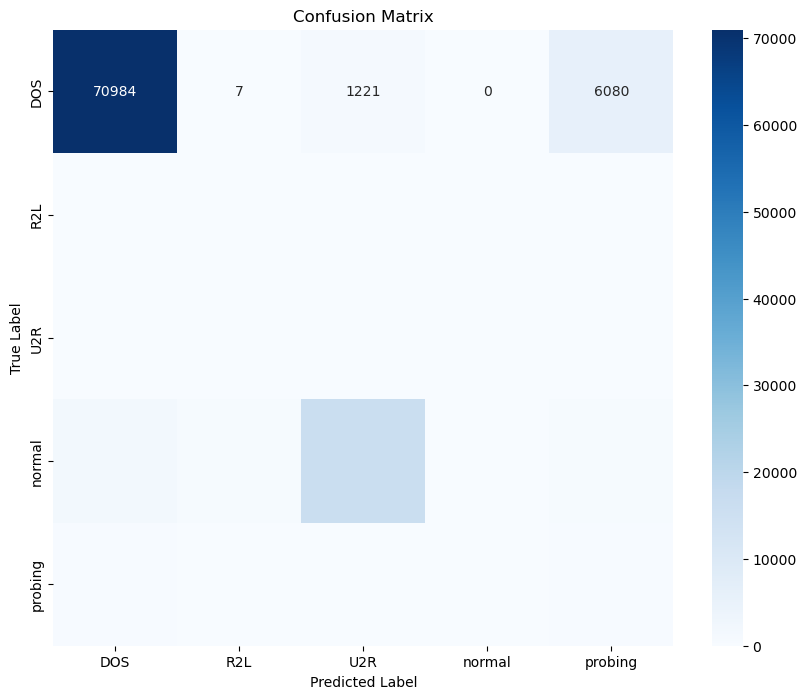

In [48]:
#plot confusion matrix for perceptron model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(Y_test_encoded, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [49]:
import joblib

# save the model
joblib.dump(clf, 'perceptronmodel.pkl')
print("Model saved as perceptronmodel.pkl.")

Model saved as perceptronmodel.pkl.


In [2]:
# plot ROC curve and find relevant metrics and do analysis on perceptron model
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc

# Get the probabilities for each class

# Get the probabilities for each class
probs = clf.decision_function(X_test_selected)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(label_encoder.classes_)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_encoded, probs[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test_encoded.ravel(), probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label=f'micro-average ROC curve (area = {roc_auc["micro"]:.2f})',
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
            label=f'macro-average ROC curve (area = {roc_auc["macro"]:.2f})',
            color='navy', linestyle=':', linewidth=4)

colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red']

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {label_encoder.classes_[i]} (area = {roc_auc[i]:.2f})')
    
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])

plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Perceptron Model')
plt.legend(loc="lower right")
plt.show()

# Compute Precision-Recall curve and relevant metrics
precision = dict()
recall = dict()
pr_auc = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(Y_test_encoded, probs[:, i], pos_label=i)
    pr_auc[i] = auc(recall[i], precision[i])

# Compute micro-average precision-recall curve and precision-recall area
precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test_encoded.ravel(), probs.ravel())
pr_auc["micro"] = auc(recall["micro"], precision["micro"])

# Compute macro-average precision-recall curve and precision-recall area

# First aggregate all false positive rates
all_recall = np.unique(np.concatenate([recall[i] for i in range(n_classes)]))

# Then interpolate all precision-recall curves at this points
mean_precision = np.zeros_like(all_recall)
for i in range(n_classes):
    mean_precision += np.interp(all_recall, recall[i], precision[i])

# Finally average it and compute AUC
mean_precision /= n_classes

recall["macro"] = all_recall
precision["macro"] = mean_precision
pr_auc["macro"] = auc(recall["macro"], precision["macro"])

# Plot all Precision-Recall curves
plt.figure(figsize=(10, 8))

plt.plot(recall["micro"], precision["micro"],
            label=f'micro-average Precision-Recall curve (area = {pr_auc["micro"]:.2f})',
            color='deeppink', linestyle=':', linewidth=4)

plt.plot(recall["macro"], precision["macro"],
            label=f'macro-average Precision-Recall curve (area = {pr_auc["macro"]:.2f})',
            color='navy', linestyle=':', linewidth=4)

colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red']

for i, color in zip(range(n_classes), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label=f'Precision-Recall curve of class {label_encoder.classes_[i]} (area = {pr_auc[i]:.2f})')
    
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Perceptron Model')
plt.legend(loc="lower right")
plt.show()

NameError: name 'clf' is not defined

In [50]:
# apply decision tree model for multiclasses
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(X_train_selected, Y_train_resampled)

# make predictions
predictions = clf.predict(X_test_selected)

# Evaluate the model
print('Classification Report:')
print(classification_report(Y_test_encoded, predictions, zero_division=0))

accuracy = accuracy_score(Y_test_encoded, predictions)
print(f"Model Accuracy: {accuracy:.4f}")

# save the model
joblib.dump(clf, 'decisiontreemodel.pkl')
print("Model saved as decisiontreemodel.pkl.")

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.99      0.89     78292
           1       0.00      0.00      0.00       225
           2       0.00      0.00      0.00        10
           3       0.96      0.05      0.10     19456
           4       0.00      0.00      0.00       822

    accuracy                           0.80     98805
   macro avg       0.35      0.21      0.20     98805
weighted avg       0.82      0.80      0.72     98805

Model Accuracy: 0.7982
Model saved as decisiontreemodel.pkl.


In [53]:
# apply softmax regression model for multiclasses
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
clf.fit(X_train_selected, Y_train_resampled)

# make predictions
predictions = clf.predict(X_test_selected)

# Evaluate the model
print('Classification Report:')
print(classification_report(Y_test_encoded, predictions, zero_division=0))

accuracy = accuracy_score(Y_test_encoded, predictions)
print(f"Model Accuracy: {accuracy:.4f}")

# save the model
joblib.dump(clf, 'softmaxregressionmodel.pkl')
print("Model saved as softmaxregressionmodel.pkl.")

/home/dcll/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     78292
           1       0.01      0.04      0.02       225
           2       0.00      1.00      0.00        10
           3       0.00      0.00      0.00     19456
           4       0.00      0.00      0.00       822

    accuracy                           0.79     98805
   macro avg       0.19      0.41      0.20     98805
weighted avg       0.75      0.79      0.77     98805

Model Accuracy: 0.7860
Model saved as softmaxregressionmodel.pkl.


In [ ]:
# apply SVM model for multiclasses
from sklearn.svm import SVC

clf = SVC(kernel='rbf', C=1.0, gamma='scale', decision_function_shape='ovr', random_state=42)
clf.fit(X_train_selected, Y_train_resampled)

# make predictions
predictions = clf.predict(X_test_selected)

# Evaluate the model
print('Classification Report:')
print(classification_report(Y_test, predictions, zero_division=0))

accuracy = accuracy_score(Y_test, predictions)
print(f"Model Accuracy: {accuracy:.4f}")

# save the model
joblib.dump(clf, 'svmmodel.pkl')
print("Model saved as svmmodel.pkl.")

In [54]:
# apply lazy predict for multiclass classification
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train_selected, X_test_selected, Y_train_resampled, Y_test_encoded)

print(models)

ModuleNotFoundError: No module named 'lazypredict'

1. feature report from claude also look for feature selection techniques from literature papers
2. data vizualization
3. why which preprocessing technique is used
4. collect all results
5. study results and plots